<a href="https://colab.research.google.com/github/z-guard/analysis/blob/main/notebooks/sports_facility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# スポーツ施設(体育館、プール、運動場)
- input:
    - 区ごとの運動施設の位置情報
- output:
    - sports_score.csv
        - 体育館スコア
        - プールスコア
        - 運動場スコア

In [1]:
!pip install -q geocoder
!pip install -q --upgrade xlrd
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
output_score_file = 'sports_score.csv'
output_master_file = 'sports_master.csv'

In [5]:
import os
import requests
import json
import pandas as pd
import numpy as np
from urllib.parse import urlparse
import geocoder
import math
import io
import re
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [6]:
def get_data_csv_url(url, encoding='utf-8', excel=False):
    res = requests.get(url)
    if res.status_code == 200:
        if not excel:
            return pd.read_csv(io.BytesIO(res.content), encoding=encoding)
        else:
            return pd.read_excel(io.BytesIO(res.content))
    else:
        raise Exception(f'status_code: {res.status_code} ({url})')

# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, (lat, lon) in enumerate(zip(df_master['緯度'].values, df_master['経度'].values)):
        dist = _df_cat[
            ((_df_cat['緯度'] - lat).abs() < 0.04) &    # 約4km以内
            ((_df_cat['経度'] - lon).abs() < 0.04)      # 約4km以内
        ].apply(lambda x: get_distance(x['緯度'], x['経度'], lat, lon), axis=1)
        val = np.NaN
        if len(dist) > 0:
            if method == 'min':
                # 最小の距離
                val = dist.min()
            elif method == 'count':
                # {param}km以内の施設の数をカウント
                val = len(dist[dist <= param])
            elif method == 'mean':
                # 近い{param}件の距離の平均
                val = dist.sort_values()[:param].mean()
        else:
            print(f'{category} not found {i}')
        cat_values.append(val)
    return cat_values

In [7]:
def get_category_facility(name):
    if re.search('.*公園$', name) is not None:
        return '公園'
    if re.search('.*緑地$', name) is not None:
        return '公園'
    if re.search('.*緑道$', name) is not None:
        return '公園'
    if re.search('.*庭園$', name) is not None:
        return '公園'
    if re.search('.*児童遊園$', name) is not None:
        return '公園'
    if re.search('.*図書館$', name) is not None:
        return '図書館'
    if re.search('.*美術館$', name) is not None:
        return '文化施設'
    if re.search('.*博物館$', name) is not None:
        return '文化施設'
    if re.search('.*会館$', name) is not None:
        return '文化施設'
    if re.search('.*劇場$', name) is not None:
        return '文化施設'
    if re.search('アーツ', name) is not None:
        return '文化施設'
    if re.search('.*協会$', name) is not None:
        return '協会'
    if re.search('(プール|スイム|スイミング)', name) is not None:
        return 'プール'
    if re.search('(運動場|球技場|体育場|野球場|競技場|運動広場|庭球場)', name) is not None:
        return '運動場他'
    if re.search('(サッカー|フットサル|テニス|ソフトボール|グラウンド|グランド)', name) is not None:
        return '運動場他'
    if re.search('(体育館|トレーニング|武道館)', name) is not None:
        return '体育館'
    if re.search('スポーツ', name) is not None:
        return '運動場他'
    return None

In [8]:
def change_type(df_data):
    df_data['緯度'] = df_data['緯度'].astype(float)
    df_data['経度'] = df_data['経度'].astype(float)

In [9]:
extract_columns = ['施設分類', '名称', '市区町村名', '所在地', '緯度', '経度']

## 0. 東京都

## 1. 千代田区
- [スポーツ施設のご案内](https://www.city.chiyoda.lg.jp/koho/bunka/sports/tairyoku.html)

In [10]:
df_chiyoda_sports = pd.read_csv(os.path.join(DIR_NAME, 'original/千代田区_スポーツ施設.csv'), encoding='utf-8')
print(df_chiyoda_sports.shape)

df_chiyoda_sports = df_chiyoda_sports[
    df_chiyoda_sports['施設分類'].isin(['体育館', '運動場他', 'プール'])
][extract_columns].reset_index(drop=True)
print(df_chiyoda_sports.shape)

(16, 6)
(16, 6)


In [11]:
df_chiyoda_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,体育館,スポーツセンター,千代田区,内神田2-1-8,35.689165,139.767456
1,プール,スポーツセンター温水プール,千代田区,内神田2-1-8,35.689165,139.767456
2,運動場他,外濠公園総合グラウンド,千代田区,五番町,35.688860,139.730872
3,運動場他,花小金井運動施設,千代田区,花小金井南町3-2-7,35.721006,139.517968
4,運動場他,夢の島東少年野球場,千代田区,江東区夢の島,35.652324,139.829138


## 2. 中央区
- [スポーツ・レクリエーション施設](https://www.city.chuo.lg.jp/sisetugaido/supotu/index.html)

In [12]:
df_chuou_sports = pd.read_csv(os.path.join(DIR_NAME, 'original/中央区_スポーツ施設.csv'), encoding='utf-8')
print(df_chuou_sports.shape)

df_chuou_sports = df_chuou_sports[
    df_chuou_sports['施設分類'].isin(['体育館', '運動場他', 'プール'])
][extract_columns].reset_index(drop=True)
print(df_chuou_sports.shape)

(11, 6)
(11, 6)


In [13]:
df_chuou_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,運動場他,江戸川河川敷野球場・サッカー場,中央区,三郷市岩野木,35.834635,139.885462
1,体育館,総合スポーツセンター,中央区,日本橋浜町ニ丁目59番1号,35.687943,139.789138
2,プール,総合スポーツセンター温水プール,中央区,日本橋浜町ニ丁目59番1号,35.687943,139.789138
3,プール,月島スポーツプラザ温水プール,中央区,月島一丁目9番2号,35.665205,139.783126
4,運動場他,浜町運動場,中央区,日本橋浜町２丁目５９,35.688904,139.784132


## 3. 港区
- [スポーツ・健康増進施設・公衆浴場](https://catalog.data.metro.tokyo.lg.jp/dataset/t131032d0000000014/resource/84bb03cb-c38a-4381-b5bf-9d4d9ed5e889)

In [14]:
minato_sports_url = 'https://opendata.city.minato.tokyo.jp/dataset/bb1f719a-ffbe-4c29-a936-de0bf6a2d179/resource/d2d0e539-a18c-4f96-a6aa-7cd9e6f0676f/download/minatokushisetsujoho_sports.csv'
df_minato_sports = get_data_csv_url(minato_sports_url)
print(df_minato_sports.shape)

df_minato_sports['市区町村名'] = '港区'
df_minato_sports['施設分類'] = df_minato_sports['ページタイトル'].apply(get_category_facility)
df_minato_sports = df_minato_sports[
    (df_minato_sports['施設分類'].isin(['体育館', '運動場他', 'プール']))
].rename(columns={'ページタイトル':'名称'})[extract_columns].reset_index(drop=True)
change_type(df_minato_sports)
print(df_minato_sports.shape)

(18, 31)
(14, 6)


In [15]:
df_minato_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,プール,港南小学校屋内プール,港区,港区港南四丁目3番28号 港区立港南小学校1階,35.629570,139.749656
1,プール,高陵中学校屋内プール,港区,港区西麻布四丁目14番8号 港区立高陵中学校地下2階,35.657139,139.720463
2,運動場他,芝浦南ふ頭公園運動広場（かいがんぱ～く）,港区,港区海岸三丁目33番20号,35.637322,139.759891
3,運動場他,港区スポーツセンター,港区,港区芝浦一丁目16番1号 みなとパーク芝浦3～8階,35.646408,139.751501
4,運動場他,埠頭少年野球場,港区,港区海岸三丁目14番34号,35.641684,139.755597


## 4. 新宿区
- [スポーツ施設案内](https://www.city.shinjuku.lg.jp/kanko/260500community_00014.html)

In [16]:
df_shinjuku_sports = pd.read_csv(os.path.join(DIR_NAME, 'original/新宿区_スポーツ施設.csv'), encoding='utf-8')
print(df_shinjuku_sports.shape)

df_shinjuku_sports = df_shinjuku_sports[
    df_shinjuku_sports['施設分類'].isin(['体育館', '運動場他', 'プール'])
][extract_columns].reset_index(drop=True)
print(df_shinjuku_sports.shape)

(17, 6)
(17, 6)


In [17]:
df_shinjuku_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,体育館,新宿スポーツセンター,新宿区,大久保３丁目５−１,35.706966,139.703332
1,プール,新宿スポーツセンタープール,新宿区,大久保３丁目５−１,35.706966,139.703332
2,体育館,新宿コズミックスポーツセンター,新宿区,大久保３丁目１−２,35.704900,139.707915
3,プール,新宿コズミックスポーツセンタープール,新宿区,大久保３丁目１−２,35.704900,139.707915
4,体育館,大久保スポーツプラザ,新宿区,大久保３丁目７−４２,35.706631,139.702227


## 5. 文京区
- [文化・スポーツ施設](https://catalog.data.metro.tokyo.lg.jp/dataset/t131059d0304010001/resource/4fb225b9-c79c-47bc-bfe3-adec3f729906)
- [スポーツ施設](https://www.city.bunkyo.lg.jp/bunka/sports/shisetsu.html)

In [18]:
bunkyo_sports_url = 'https://www.city.bunkyo.lg.jp/library/opendata-bunkyo/03bunka-kankou-sports/01bunka-sports/bunka-sports.csv'
df_bunkyo_sports = get_data_csv_url(bunkyo_sports_url, encoding='shift-jis')
print(df_bunkyo_sports.shape)

df_bunkyo_sports['市区町村名'] = '文京区'
df_bunkyo_sports = df_bunkyo_sports[df_bunkyo_sports['カテゴリ'] == 'スポーツ施設'].reset_index(drop=True)
df_bunkyo_sports['施設分類'] = df_bunkyo_sports['施設名'].apply(get_category_facility)
df_bunkyo_sports = df_bunkyo_sports[
    (df_bunkyo_sports['施設分類'].isin(['体育館', '運動場他', 'プール']))
].rename(columns={'施設名':'名称', '住所':'所在地'})[extract_columns].reset_index(drop=True)
change_type(df_bunkyo_sports)
print(df_bunkyo_sports.shape)

(15, 14)
(7, 6)


In [19]:
df_bunkyo_sports

,施設分類,名称,市区町村名,所在地,緯度,経度
0,体育館,文京総合体育館,文京区,東京都文京区本郷7丁目1番2号,35.708382,139.763180
1,運動場他,文京スポーツセンター,文京区,東京都文京区大塚3丁目29番2号,35.720522,139.736420
2,体育館,文京江戸川橋体育館,文京区,東京都文京区小日向1丁目7番4号,35.710603,139.735460
3,運動場他,六義公園運動場,文京区,東京都文京区本駒込6丁目16番10号,35.731305,139.745763
4,運動場他,小石川運動場,文京区,東京都文京区後楽1丁目8番23号,35.704965,139.746415
5,運動場他,後楽公園少年野球場,文京区,東京都文京区後楽1丁目6番25号,35.706528,139.748556
6,運動場他,竹早テニスコート,文京区,東京都文京区小石川5丁目9番1号,35.717161,139.739597


## 6. 台東区
- [スポーツ](https://catalog.data.metro.tokyo.lg.jp/dataset/t131067d0000000091/resource/a7138b99-a872-41fd-ab3b-361a8278bff7)

In [20]:
taito_sports_url = 'https://www.city.taito.lg.jp/kusei/online/opendata/seikatu/shisethutizujouhou.files/sisetu_13.csv'
df_taito_sports = get_data_csv_url(taito_sports_url, 'shift-jis')
print(df_taito_sports.shape)

df_taito_sports['市区町村名'] = '台東区'
df_taito_sports['施設分類'] = df_taito_sports['名称'].apply(get_category_facility)
df_taito_sports = df_taito_sports[
    (df_taito_sports['施設分類'].isin(['体育館', '運動場他', 'プール']))
].rename(columns={'X座標':'経度', 'Y座標':'緯度'})[extract_columns].reset_index(drop=True)
change_type(df_taito_sports)
print(df_taito_sports.shape)

(8, 8)
(8, 6)


In [21]:
df_taito_sports

,施設分類,名称,市区町村名,所在地,緯度,経度
0,プール,清島温水プール,台東区,東上野6丁目16番8号,35.713494,139.783434
1,運動場他,柳北スポーツプラザ,台東区,浅草橋5丁目1番8号（旧柳北小学校体育館）,35.699276,139.782265
2,運動場他,台東リバーサイドスポーツセンター,台東区,今戸1丁目1番10号,35.717405,139.804583
3,体育館,生涯学習センタートレーニングルーム,台東区,西浅草3丁目25番16号 生涯学習センター3階,35.717238,139.789697
4,運動場他,荒川河川敷運動公園運動場,台東区,足立区千住大川町12番1号先（荒川河川敷）,35.758178,139.800661
5,運動場他,江戸川河川敷野球場,台東区,埼玉県三郷市新和地先（江戸川河川敷）,35.819153,139.888761
6,運動場他,たなかスポーツプラザ,台東区,日本堤2丁目25番4号,35.727879,139.797257
7,プール,都立浅草高等学校温水プール(区民開放期間のみ）,台東区,今戸1丁目8番13号 都立浅草高等学校体育館棟地下1階,35.719356,139.802486


## 7. 墨田区
- [スポーツ施設](https://catalog.data.metro.tokyo.lg.jp/dataset/t131075d0000000097/resource/8544959b-5b18-4c8d-94ab-1f8db69f7445)


In [22]:
sumida_sports_url = 'https://www.city.sumida.lg.jp/kuseijoho/sumida_info/opendata/opendata_ichiran/shisetsu_data.files/sports.csv'
df_sumida_sports = get_data_csv_url(sumida_sports_url, 'shift-jis')
print(df_sumida_sports.shape)

df_sumida_sports['市区町村名'] = '墨田区'
df_sumida_sports['施設分類'] = df_sumida_sports['施設名称'].apply(get_category_facility)
df_sumida_sports = df_sumida_sports[
    (df_sumida_sports['施設分類'].isin(['体育館', '運動場他', 'プール']))
].rename(columns={'施設名称':'名称'})[extract_columns].reset_index(drop=True)
change_type(df_sumida_sports)
print(df_sumida_sports.shape)

(33, 6)
(28, 6)


In [23]:
df_sumida_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,体育館,墨田区総合体育館,墨田区,墨田区錦糸四丁目15番1号,35.699416,139.817188
1,運動場他,スポーツプラザ梅若,墨田区,墨田区墨田一丁目4番4号,35.729064,139.815837
2,体育館,立花体育館,墨田区,墨田区立花一丁目25番10号,35.705186,139.832020
3,運動場他,すみだスポーツ健康センター,墨田区,墨田区東墨田一丁目6番1号,35.716461,139.830555
4,プール,両国屋内プール,墨田区,墨田区横網一丁目8番1号 両国中学校内,35.697809,139.796259


## 8. 江東区
- [スポーツセンター](https://catalog.data.metro.tokyo.lg.jp/dataset/t131083d0000000007/resource/4ca870cd-859a-4f9e-8e57-38d9830aadc4)

In [24]:
koutou_sports_url = 'https://www.city.koto.lg.jp/012107/documents/131083_kotocity_public_facility-4_sports.csv'
df_koutou_sports = get_data_csv_url(koutou_sports_url, 'shift-jis')
print(df_koutou_sports.shape)

df_koutou_sports['施設分類'] = df_koutou_sports['名称'].apply(get_category_facility)
df_koutou_sports = df_koutou_sports[
    (df_koutou_sports['施設分類'].isin(['体育館', '運動場他', 'プール']))
].rename(columns={'住所':'所在地'})[extract_columns].reset_index(drop=True)
change_type(df_koutou_sports)
print(df_koutou_sports.shape)

(19, 39)
(17, 6)


In [25]:
df_koutou_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,運動場他,深川スポーツセンター,江東区,江東区越中島1-2-18,35.670692,139.791745
1,運動場他,亀戸スポーツセンター,江東区,江東区亀戸8-22-1,35.700432,139.836565
2,運動場他,有明スポーツセンター,江東区,江東区有明2-3-5,35.633500,139.783824
3,運動場他,東砂スポーツセンター,江東区,江東区東砂4-24-1,35.679506,139.839551
4,運動場他,深川北スポーツセンター,江東区,江東区平野3-2-20,35.677172,139.805179


## 9. 品川区
- [文化・スポーツ施設・公園(csv形式)](https://catalog.data.metro.tokyo.lg.jp/dataset/t131091d0000000016/resource/bd07c1ef-65b9-4bfc-88bd-0e4771782cc4) -> 体育館、野球場

In [26]:
# 列がおかしいので読み込みできない
# shinagawa_sports_url = 'https://www.opendata.metro.tokyo.lg.jp/shinagawa/culture_sports_park.csv'
# df_shinagawa_sports = get_data_csv_url(shinagawa_sports_url, encoding='cp932')
df_shinagawa_sports = pd.read_csv(os.path.join(DIR_NAME, 'original/品川区_文化スポーツ施設.csv'), encoding='cp932', names=['名称', '所在地', '備考', '緯度', '経度'], skiprows=1)
print(df_shinagawa_sports.shape)

df_shinagawa_sports['市区町村名'] = '品川区'
df_shinagawa_sports['施設分類'] = df_shinagawa_sports['名称'].apply(get_category_facility)
df_shinagawa_sports = df_shinagawa_sports
df_shinagawa_sports = df_shinagawa_sports[
    (df_shinagawa_sports['施設分類'].isin(['体育館', '運動場他', 'プール']))
][extract_columns].reset_index(drop=True)
df_shinagawa_sports = df_shinagawa_sports.drop_duplicates(subset=['所在地']).reset_index(drop=True)
change_type(df_shinagawa_sports)
print(df_shinagawa_sports.shape)

(314, 5)
(12, 6)


In [27]:
df_shinagawa_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,体育館,総合体育館,品川区,東京都品川区北品川5-6-11,35.624530,139.728488
1,運動場他,天王洲公園野球場,品川区,東京都品川区東品川2-5-42,35.620512,139.749802
2,運動場他,八潮北公園野球場,品川区,東京都品川区八潮1-3-1,35.612284,139.754404
3,運動場他,大井ふ頭中央海浜公園野球場,品川区,東京都品川区八潮4-1-19,35.590939,139.752439
4,運動場他,子供の森野球場,品川区,東京都品川区北品川3-10-13,35.616218,139.737565


## 10. 目黒区
- [公共施設_2022_06/29](https://data.bodik.jp/dataset/131105_public_facility/resource/f119ff15-e5e1-44e7-836f-aa5e20c9a46c) -> 体育館、プール

In [28]:
megro_facility_url = 'https://data.bodik.jp/dataset/8fb2f443-a8fd-47c6-a527-6a961fca8928/resource/f119ff15-e5e1-44e7-836f-aa5e20c9a46c/download/131105_public_facility_20220616.csv'
df_megro_facility = get_data_csv_url(megro_facility_url, 'cp932')
print(df_megro_facility.shape)

df_megro_facility['施設分類'] = df_megro_facility['名称'].apply(get_category_facility)
df_megro_facility = df_megro_facility[
    (df_megro_facility['施設分類'].isin(['体育館', '運動場他', 'プール']))
].rename(columns={'住所':'所在地'})[extract_columns].drop_duplicates(subset=['施設分類', '所在地']).reset_index(drop=True)
change_type(df_megro_facility)
print(df_megro_facility.shape)

(395, 24)
(15, 6)


In [29]:
df_megro_facility.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,体育館,中央体育館,目黒区,東京都目黒区目黒本町 5-22-8,35.619030,139.698961
1,体育館,駒場体育館,目黒区,東京都目黒区駒場 2-19-39,35.658083,139.680147
2,プール,駒場プール,目黒区,東京都目黒区駒場 2-19-39,35.658083,139.680147
3,運動場他,駒場庭球場・ゲートボール場,目黒区,東京都目黒区駒場 2-19-39,35.658083,139.680147
4,体育館,目黒区民センター体育館,目黒区,東京都目黒区目黒 2-4-36,35.635403,139.708472


## 11. 大田区
- [スポーツ施設](https://www.city.ota.tokyo.jp/shisetsu/sports/index.html)

In [30]:
df_oota_sports = pd.read_csv(os.path.join(DIR_NAME, 'original/大田区_スポーツ施設.csv'), encoding='utf-8')
print(df_oota_sports.shape)

df_oota_sports = df_oota_sports[
    df_oota_sports['施設分類'].isin(['体育館', '運動場他', 'プール'])
][extract_columns].reset_index(drop=True)
print(df_oota_sports.shape)

(20, 6)
(20, 6)


In [31]:
df_oota_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,運動場他,昭和島運動場野球場,大田区,昭和島一丁目7番,35.570934,139.746190
1,運動場他,平和島公園野球場,大田区,平和島四丁目2番2号,35.582272,139.741045
2,運動場他,東調布公園野球場,大田区,南雪谷五丁目13番1号,35.589103,139.687076
3,運動場他,萩中公園野球場,大田区,萩中三丁目26番46号,35.549642,139.737869
4,運動場他,多摩川緑地野球場,大田区,西六郷４丁目,35.541153,139.700230


## 12. 世田谷区
- [スポーツ](https://www.city.setagaya.lg.jp/theme/kanko/005/index.html) -> CSVでない
- [公園、文化・スポーツ関係施設](https://data-setagaya.opendata.arcgis.com/datasets/setagaya::%E5%85%AC%E5%9C%92%E3%80%81%E6%96%87%E5%8C%96%E3%83%BB%E3%82%B9%E3%83%9D%E3%83%BC%E3%83%84%E9%96%A2%E4%BF%82%E6%96%BD%E8%A8%AD/explore)

In [32]:
df_setagaya_sports = pd.read_csv(os.path.join(DIR_NAME, 'original/世田谷区_公園文化スポーツ関連施設.csv'), encoding='utf-8', 
                                 names=['経度', '緯度', 'ID', '名称', 'カテゴリ1', 'カテゴリ2', '所在地', '備考', 'URL'], skiprows=1)
print(df_setagaya_sports.shape)

df_setagaya_sports['市区町村名'] = '世田谷区'
df_setagaya_sports['施設分類'] = df_setagaya_sports['名称'].apply(get_category_facility)
df_setagaya_sports = df_setagaya_sports
df_setagaya_sports = df_setagaya_sports[
    (df_setagaya_sports['施設分類'].isin(['体育館', '運動場他', 'プール']))
][extract_columns].reset_index(drop=True)
change_type(df_setagaya_sports)
print(df_setagaya_sports.shape)

(76, 9)
(23, 6)


In [33]:
df_setagaya_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,運動場他,玉川野毛町公園スポーツ施設,世田谷区,野毛1-25-1,35.605715,139.643353
1,プール,玉川野毛町プール,世田谷区,野毛1-25-1,35.605899,139.641382
2,体育館,尾山台地域体育館,世田谷区,尾山台3-19-3,35.604991,139.654285
3,運動場他,二子玉川緑地運動場,世田谷区,鎌田1-3-5,35.616860,139.619157
4,運動場他,リコー砧総合運動場,世田谷区,宇奈根1-5-1,35.618884,139.605881


## 13. 渋谷区
- [スポーツ施設](https://www.city.shibuya.tokyo.jp/shisetsu/sports/index.html) -> CSVでない

In [34]:
df_shibuya_sports = pd.read_csv(os.path.join(DIR_NAME, 'original/渋谷区_スポーツ施設.csv'), encoding='utf-8')
print(df_shibuya_sports.shape)

df_shibuya_sports = df_shibuya_sports[
    df_shibuya_sports['施設分類'].isin(['体育館', '運動場他', 'プール'])
][extract_columns].reset_index(drop=True)
print(df_shibuya_sports.shape)

(14, 6)
(14, 6)


In [35]:
df_shibuya_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,運動場他,スポーツセンター運動場,渋谷区,西原１丁目４０−１８,35.675639,139.681262
1,体育館,スポーツセンター体育館,渋谷区,西原１丁目４０−１８,35.675639,139.681262
2,プール,スポーツセンタープール,渋谷区,西原１丁目４０−１８,35.675639,139.681262
3,運動場他,二子玉川区民運動施設,渋谷区,玉川３丁目３−１１,35.612783,139.624436
4,運動場他,代々木西原公園庭球場,渋谷区,西原１丁目４７−８,35.673421,139.684051


## 14. 中野区
- [中野区オープンデータ 公共施設一覧（公園等以外）](https://www.city.tokyo-nakano.lg.jp/dept/158100/d027582.html) -> 体育館、運動場

In [36]:
nakano_facility_url = 'https://www.city.tokyo-nakano.lg.jp/dept/158100/d027582_d/fil/131148_public_facility.csv'
df_nakano_facility = get_data_csv_url(nakano_facility_url)
print(df_nakano_facility.shape)

df_nakano_facility['施設分類'] = df_nakano_facility['名称'].apply(get_category_facility)
df_nakano_facility = df_nakano_facility[
    (df_nakano_facility['施設分類'].isin(['体育館', '運動場他', 'プール']))
].rename(columns={'住所': '所在地'})[extract_columns].drop_duplicates(subset=['施設分類', '所在地']).reset_index(drop=True)
change_type(df_nakano_facility)
print(df_nakano_facility.shape)

(180, 39)
(7, 6)


In [37]:
df_nakano_facility.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,体育館,中野体育館,中野区,東京都中野区中野4-11-14,35.709118,139.662613
1,運動場他,鷺宮スポーツ・コミュニティプラザ,中野区,東京都中野区白鷺3-1-13,35.722069,139.636032
2,運動場他,中部スポーツ・コミュニティプラザ,中野区,東京都中野区中央3-19-1,35.700085,139.674225
3,運動場他,南部スポーツ・コミュニティプラザ,中野区,東京都中野区弥生町5-11-26,35.688080,139.668823
4,運動場他,上高田運動施設（野球場、庭球場）,中野区,東京都中野区上高田5-6-1,35.717289,139.678436


## 15. 杉並区
- [オープンデータ一覧](https://www2.wagmap.jp/suginami/opendata?type=shp&ly=930)

In [38]:
df_suginami_sports = pd.read_csv(os.path.join(DIR_NAME, 'original/杉並区_スポーツ施設.csv'))
print(df_suginami_sports.shape)

df_suginami_sports['施設分類'] = df_suginami_sports['分類'].str.strip()
df_suginami_sports.loc[df_suginami_sports['施設分類'] == '運動場', '施設分類'] = '運動場他'
df_suginami_sports['市区町村名'] = '杉並区'
df_suginami_sports = df_suginami_sports.rename(columns={'住所':'所在地'})[extract_columns]
change_type(df_suginami_sports)
print(df_suginami_sports.shape)

(21, 9)
(21, 6)


In [39]:
df_suginami_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,運動場他,井草森公園運動場,杉並区,井草4丁目12番1号,35.726903,139.611067
1,運動場他,柏の宮公園庭球場,杉並区,浜田山2丁目5番1号,35.678948,139.625214
2,運動場他,TAC杉並区上井草スポーツセンター（運動場）,杉並区,上井草3丁目34番1号,35.722923,139.601737
3,運動場他,蚕糸の森公園運動場,杉並区,和田3丁目55番49号,35.697234,139.656746
4,運動場他,下高井戸運動場,杉並区,下高井戸3丁目26番1号,35.672959,139.635498


## 16. 豊島区
- [公共施設一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t131164d0000000010/resource/472e6a97-b350-4909-a939-76530a570324)

In [40]:
url_toshima_facility = 'https://www.opendata.metro.tokyo.lg.jp/toyoshima/R4_public_facility.csv'
df_toshima_facility = get_data_csv_url(url_toshima_facility, encoding='cp932')
print(df_toshima_facility.shape)

df_toshima_facility['施設分類'] = df_toshima_facility['名称'].apply(get_category_facility)
df_toshima_facility = df_toshima_facility[
    (df_toshima_facility['施設分類'].isin(['体育館', '運動場他', 'プール']))
].rename(columns={'住所': '所在地'})[extract_columns].reset_index(drop=True)
change_type(df_toshima_facility)
print(df_toshima_facility.shape)

(538, 24)
(9, 6)


In [41]:
df_toshima_facility

,施設分類,名称,市区町村名,所在地,緯度,経度
0,体育館,巣鴨体育館,豊島区,東京都豊島区巣鴨3-8-7,35.73415,139.73347
1,運動場他,池袋スポーツセンター,豊島区,東京都豊島区上池袋2-5-1,35.73480,139.71475
2,体育館,雑司が谷体育館,豊島区,東京都豊島区雑司が谷3-1-7,35.71957,139.71385
3,運動場他,南長崎中央公園スポーツセンター,豊島区,東京都豊島区南長崎4-13-5,35.72449,139.68369
4,体育館,豊島体育館,豊島区,東京都豊島区要町3-47-8,35.73994,139.68948
5,運動場他,西巣鴨体育場,豊島区,東京都豊島区西巣鴨4-22-19,35.74472,139.73116
6,運動場他,総合体育場,豊島区,東京都豊島区東池袋4-41-30,35.72938,139.72264
7,運動場他,三芳グランド,豊島区,埼玉県入間郡三芳町上富382-1,35.82965,139.51230
8,運動場他,荒川野球場,豊島区,東京都板橋区新河岸3荒川河川敷,35.79680,139.65254


## 17. 北区
- [スポーツ施設案内](https://www.city.kita.tokyo.jp/bunka/sport/shisetsu/index.html)

In [42]:
df_kita_sports = pd.read_csv(os.path.join(DIR_NAME, 'original/北区_スポーツ施設.csv'), encoding='utf-8')
print(df_kita_sports.shape)

df_kita_sports = df_kita_sports[
    df_kita_sports['施設分類'].isin(['体育館', '運動場他', 'プール'])
][extract_columns].reset_index(drop=True)
print(df_kita_sports.shape)

(17, 6)
(17, 6)


In [43]:
df_kita_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,運動場他,北ノ台スポーツ多目的広場,北区,上十条５丁目１４−４,35.764285,139.713469
1,体育館,北ノ台スポーツ多目的広場体育館,北区,上十条５丁目１４−４,35.764285,139.713469
2,運動場他,北運動場,北区,神谷２丁目４７−６,35.774646,139.727812
3,運動場他,赤羽スポーツの森公園競技場,北区,赤羽西５丁目２−２７,35.772282,139.708680
4,運動場他,豊島北スポーツ多目的広場,北区,豊島５丁目３−１３,35.764723,139.750022


## 18. 荒川区
- [スポーツ施設一覧](https://www.city.arakawa.tokyo.jp/a017/shisetsuannai/sisetuyoyaku/supotsusisetsu.html)

In [44]:
df_arakawa_sports = pd.read_csv(os.path.join(DIR_NAME, 'original/荒川区_スポーツ施設.csv'), encoding='utf-8')
print(df_arakawa_sports.shape)

df_arakawa_sports = df_arakawa_sports[
    df_arakawa_sports['施設分類'].isin(['体育館', '運動場他', 'プール'])
][extract_columns].reset_index(drop=True)
print(df_arakawa_sports.shape)

(12, 6)
(12, 6)


In [45]:
df_arakawa_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,運動場他,西新井橋野球場,荒川区,千住元町,35.757768,139.791421
1,運動場他,南千住野球場,荒川区,南千住６丁目４５−５,35.736233,139.791563
2,運動場他,少年運動場野球場,荒川区,小台一丁目22番地,35.755915,139.771965
3,運動場他,区民運動場グラウンド・小広場,荒川区,西尾久３丁目１４−３,35.752527,139.764330
4,運動場他,あらかわ遊園運動場,荒川区,西尾久８丁目３−１,35.751264,139.757072


## 19. 板橋区
- [どこでも誰でもおでかけマップオープンデータ（公共施設）](https://catalog.data.metro.tokyo.lg.jp/dataset/t131199d0000000761/resource/0fb29627-2244-4647-a2e4-3c1daef472ad) -> 体育館、プール
- [体育施設](https://www.city.itabashi.tokyo.jp/bunka/1005245/index.html)

In [47]:
url_itabashi_facility = 'https://www.city.itabashi.tokyo.jp/_res/projects/default_project/_page_/001/006/127/r3-1.csv'
df_itabashi_facility = get_data_csv_url(url_itabashi_facility, encoding='shift-jis')
print(df_itabashi_facility.shape)

df_itabashi_facility['市区町村名'] = '板橋区'
df_itabashi_facility['施設分類'] = df_itabashi_facility['施設名称'].apply(get_category_facility)
df_itabashi_facility['緯度'] = df_itabashi_facility['GEOM'].apply(lambda x: x.split(':')[1])
df_itabashi_facility['経度'] = df_itabashi_facility['GEOM'].apply(lambda x: x.split(':')[0])
df_itabashi_facility = df_itabashi_facility[
    (df_itabashi_facility['施設分類'].isin(['体育館', '運動場他', 'プール']))
].rename(columns={'施設名称':'名称', '住所':'所在地'})[extract_columns]

df_itabashi_sports = pd.read_csv(os.path.join(DIR_NAME, 'original/板橋区_運動場.csv'))
print(df_itabashi_sports.shape)
df_itabashi_facility = pd.concat([df_itabashi_facility, df_itabashi_sports]).reset_index(drop=True)

change_type(df_itabashi_facility)
print(df_itabashi_facility.shape)

In [ ]:
df_itabashi_facility.head()

## 20. 練馬区
- [体育館](https://catalog.data.metro.tokyo.lg.jp/dataset/t131202d0000000101/resource/a239eafb-449a-4e56-85fc-c6c0146e4f0e)
- [公園・スポーツ](https://www.city.nerima.tokyo.jp/shisetsu/koen/index.html#cms0276B)

In [ ]:
url_nerima_sports = 'https://www.city.nerima.tokyo.jp/kusei/tokei/opendata/opendatasite/sisetsujyouhou/taiikukan.files/56_taiikukan.csv'
df_nerima_sports = get_data_csv_url(url_nerima_sports, encoding='shift-jis')
print(df_nerima_sports.shape)
df_nerima_sports['市区町村名'] = '練馬区'
df_nerima_sports['施設分類'] = '体育館'
df_nerima_sports = df_nerima_sports[extract_columns]

df_nerima_pool = pd.read_csv(os.path.join(DIR_NAME, 'original/練馬区_運動場プール.csv'))
print(df_nerima_pool.shape)
df_nerima_sports = pd.concat([df_nerima_sports, df_nerima_pool]).reset_index(drop=True)
change_type(df_nerima_sports)
print(df_nerima_sports.shape)

In [ ]:
df_nerima_sports.head()

## 21. 足立区
- 足立区_スポーツ施設

In [ ]:
import xml.etree.ElementTree as ET

def dump_node(node, dump_list):
    if node.text is not None:
        node_txt = node.text.strip()
        if len(node_txt) > 0:
            dump_list.append(node_txt)
    for child in node:
        dump_node(child, dump_list)

In [ ]:
tree = ET.parse(os.path.join(DIR_NAME, 'original/足立区_スポーツ施設.kml'))
dump_list = []
dump_node(tree.getroot(), dump_list)

key_list = ['名称', 'info', 'icon', 'URL', '所在地', '施設', '緯度', '経度', '緯度経度']
key_num = len(key_list)

node_dict_list = []
node_dict = {}
for index, item in enumerate(dump_list[13:]):
    key_index = index % key_num
    node_dict[key_list[key_index]] = item
    if key_index == (key_num-1):
        node_dict_list.append(node_dict)
        node_dict = {}

df_adachi_sports = pd.DataFrame(node_dict_list)
print(df_adachi_sports.shape)

In [ ]:
df_adachi_sports['市区町村名'] = '足立区'
df_adachi_sports['施設分類'] = df_adachi_sports['名称'].apply(get_category_facility)
df_adachi_sports = df_adachi_sports[
    df_adachi_sports['施設分類'].isin(['体育館', '運動場他', 'プール'])
][extract_columns].reset_index(drop=True)
change_type(df_adachi_sports)
print(df_adachi_sports.shape)

In [ ]:
df_adachi_sports.head()

## 22. 葛飾区
- [スポーツ・レクリェーション施設](https://catalog.data.metro.tokyo.lg.jp/dataset/t131229d0000000002/resource/8c85a2eb-e273-402b-b558-07b19a6a3fae)

In [ ]:
url_katsushika_sports = 'https://www.opendata.metro.tokyo.lg.jp/suisyoudataset/131229__public_facility_1.csv'
df_katsushika_sports = get_data_csv_url(url_katsushika_sports, encoding='shift-jis')
df_katsushika_sports = df_katsushika_sports.dropna(how='all').reset_index(drop=True)
print(df_katsushika_sports.shape)

df_katsushika_sports['施設分類'] = df_katsushika_sports['名称（例）'].apply(get_category_facility)
df_katsushika_sports = df_katsushika_sports[df_katsushika_sports['施設分類'].isin(['体育館', '運動場他', 'プール'])].reset_index(drop=True)
df_katsushika_sports = df_katsushika_sports.rename(columns={'名称（例）':'名称', '住所':'所在地', '軽度':'経度'})[extract_columns]
change_type(df_katsushika_sports)
print(df_katsushika_sports.shape)

In [ ]:
df_katsushika_sports.head()

## 23. 江戸川区
- [スポーツ施設](https://www.city.edogawa.tokyo.jp/e028/kuseijoho/gaiyo/shisetsuguide/bunya/sportsshisetsu/index.html)
- [地図データ 公共施設](https://www.city.edogawa.tokyo.jp/e004/kuseijoho/opendata/map_data.html)

In [ ]:
df_edogawa_facility = pd.read_csv(os.path.join(DIR_NAME, 'original/江戸川区_公共施設.csv'), encoding='shift-jis')
print(df_edogawa_facility.shape)

df_edogawa_facility['市区町村名'] = '江戸川区'
df_edogawa_facility = df_edogawa_facility[
    df_edogawa_facility['施設分類'].isin(['体育館', '運動場他', 'プール'])
][extract_columns].reset_index(drop=True)
print(df_edogawa_facility.shape)

In [ ]:
df_edogawa_facility.head()

## 運動マスタ

|No.|区名|データ|
|:----|:----|:----|
|0|東京都|なし|
|1|千代田区|済み|
|2|中央区|済み|
|3|港区|済み|
|4|新宿区|済み|
|5|文京区|済み|
|6|台東区|済み|
|7|墨田区|済み|
|8|江東区|済み|
|9|品川区|済み|
|10|目黒区|済み|
|11|大田区|済み|
|12|世田谷区|済み|
|13|渋谷区|済み|
|14|中野区|済み|
|15|杉並区|済み|
|16|豊島区|済み|
|17|北区|済み|
|18|荒川区|済み|
|19|板橋区|済み|
|20|練馬区|済み|
|21|足立区|済み|
|22|葛飾区|済み|
|23|江戸川区|済み|

In [ ]:
df_sports_master = pd.concat([
    df_chiyoda_sports,
    df_chuou_sports,
    df_minato_sports,
    df_shinjuku_sports,
    df_bunkyo_sports,
    df_taito_sports,
    df_sumida_sports,
    df_koutou_sports,
    df_shinagawa_sports,
    df_megro_facility,
    df_oota_sports,
    df_setagaya_sports,
    df_shibuya_sports,
    df_nakano_facility,
    df_suginami_sports,
    df_toshima_facility,
    df_kita_sports,
    df_arakawa_sports,
    df_itabashi_facility,
    df_nerima_sports,
    df_adachi_sports,
    df_katsushika_sports,
    df_edogawa_facility,
]).reset_index(drop=True)
print(df_sports_master.shape)

### 保存

In [ ]:
# df_sports_master.to_csv(os.path.join(DIR_NAME, output_master_file), index=False, encoding='utf-8_sig')

In [112]:
df_sports_master = pd.read_csv(os.path.join(DIR_NAME, output_master_file))
print(df_sports_master.shape)

(396, 6)


In [113]:
df_sports_master.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,体育館,スポーツセンター,千代田区,内神田2-1-8,35.689165,139.767456
1,プール,スポーツセンター温水プール,千代田区,内神田2-1-8,35.689165,139.767456
2,運動場他,外濠公園総合グラウンド,千代田区,五番町,35.688860,139.730872
3,運動場他,花小金井運動施設,千代田区,花小金井南町3-2-7,35.721006,139.517968
4,運動場他,夢の島東少年野球場,千代田区,江東区夢の島,35.652324,139.829138


In [114]:
# データがある区をリストアップ
sr_count = df_sports_master['市区町村名'].value_counts()
ward_list = list(sr_count[sr_count > 5].index)
print(len(ward_list))

23


### 地理マスタ

In [115]:
df_geo_master = pd.read_csv(os.path.join(DIR_NAME, 'geocoding.csv'))[['town_id', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_geo_master.shape)

(3145, 6)


In [116]:
df_fitness_score = pd.read_csv(os.path.join(DIR_NAME, 'fitness_score.csv'))
print(df_fitness_score.shape)

(3145, 6)


In [117]:
print(df_fitness_score.columns)

Index(['town_id', 'ダンス教室(数)', 'フィットネス(数)', 'テニス教室(数)', 'ゴルフ練習場(数)',
       'スポーツ教室(数)'],
      dtype='object')


In [118]:
def rank_score(sr_data):
    rank = sr_data.rank()
    rmax = rank.max()
    rmin = rank.min()
    max_val = 5
    x = (rank - rmin)/(rmax - rmin) * max_val
    return np.clip(x, 0, max_val)

### 各種スコア

In [119]:
sports_types = ['運動場他', '体育館', 'プール']

In [120]:
%%time
for sports in sports_types:
    # 一番近い施設の距離
    df_geo_master[f'{sports}(最近傍距離)'] = get_value_of_nearest_facility(df_geo_master, df_sports_master, sports, 'min')
    # 2km以内の施設の数
    df_geo_master[f'{sports}(数)'] = get_value_of_nearest_facility(df_geo_master, df_sports_master, sports, 'count', 2)

運動場他 not found 1050
運動場他 not found 1354
運動場他 not found 1357
運動場他 not found 2830
運動場他 not found 1050
運動場他 not found 1354
運動場他 not found 1357
運動場他 not found 2830
体育館 not found 329
体育館 not found 330
体育館 not found 822
体育館 not found 824
体育館 not found 825
体育館 not found 826
体育館 not found 827
体育館 not found 828
体育館 not found 831
体育館 not found 834
体育館 not found 835
体育館 not found 836
体育館 not found 837
体育館 not found 916
体育館 not found 917
体育館 not found 918
体育館 not found 1049
体育館 not found 1050
体育館 not found 1221
体育館 not found 1222
体育館 not found 1223
体育館 not found 1224
体育館 not found 1301
体育館 not found 1320
体育館 not found 1354
体育館 not found 1357
体育館 not found 1562
体育館 not found 1563
体育館 not found 1571
体育館 not found 1572
体育館 not found 2830
体育館 not found 329
体育館 not found 330
体育館 not found 822
体育館 not found 824
体育館 not found 825
体育館 not found 826
体育館 not found 827
体育館 not found 828
体育館 not found 831
体育館 not found 834
体育館 not found 835
体育館 not found 836
体育館 not found 837
体育館 not found 916
体育館 not found 9

In [121]:
for sports in sports_types:
    df_geo_master[f'{sports}(最近傍距離)'] = df_geo_master[f'{sports}(最近傍距離)'].fillna(df_geo_master[f'{sports}(最近傍距離)'].max())
    df_geo_master[f'{sports}(数)'] = df_geo_master[f'{sports}(数)'].fillna(0).astype(int)

In [122]:
df_geo_master = pd.merge(
    df_geo_master,
    df_fitness_score,
    on='town_id', how='left'
)
assert len(df_geo_master) == len(df_fitness_score)

In [123]:
print(df_geo_master.shape)
df_geo_master.head()

(3145, 17)


,town_id,市区町村名,町名,町丁目,緯度,経度,運動場他(最近傍距離),運動場他(数),体育館(最近傍距離),体育館(数),プール(最近傍距離),プール(数),ダンス教室(数),フィットネス(数),テニス教室(数),ゴルフ練習場(数),スポーツ教室(数)
0,101003,千代田区,丸の内,丸の内１丁目,35.681560,139.767201,1.733596,1,0.845917,3,0.845917,4,0,3,0,1,1
1,101004,千代田区,丸の内,丸の内２丁目,35.680022,139.763447,2.113264,0,1.079165,3,1.079165,4,0,3,0,1,1
2,101005,千代田区,丸の内,丸の内３丁目,35.676952,139.763476,2.290654,0,1.404752,2,1.404752,4,1,5,0,2,3
3,101007,千代田区,大手町,大手町１丁目,35.688069,139.763929,1.826994,1,0.341004,4,0.341004,6,0,5,0,2,2
4,101008,千代田区,大手町,大手町２丁目,35.686301,139.768087,1.477759,2,0.323495,5,0.323495,7,0,3,0,1,0


In [124]:
all_feature_list = []
all_score_list = []

### 運動場スコア

In [125]:
score_name = '運動場スコア'
feature_list = {
    '運動場他(最近傍距離)':       {'sort': -1, 'weight': 1}, 
    '運動場他(数)':               {'sort': 1, 'weight': 0.7},
}
all_feature_list += list(feature_list.keys())
all_score_list.append(score_name)

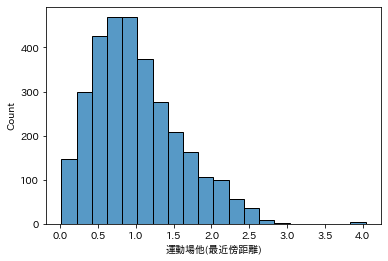

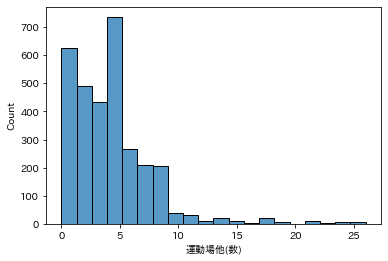

In [126]:
for feature_name in feature_list.keys():
    sns.histplot(df_geo_master[feature_name], bins=20)
    plt.show()

In [127]:
score_list = []
for key, value in feature_list.items():
    df_geo_master[f'{key}レベル'] = rank_score(df_geo_master[key] * value['sort'])
    score_list.append(df_geo_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score)

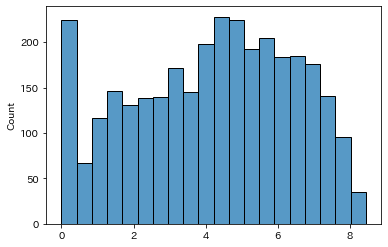

In [128]:
sns.histplot(_tmp_score, bins=20)
plt.show()

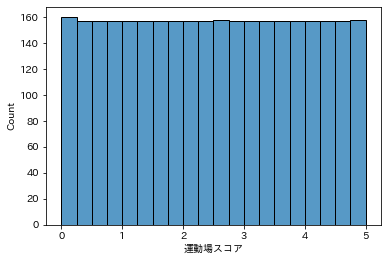

In [129]:
sns.histplot(df_geo_master[score_name], bins=20)
plt.show()

In [130]:
df_geo_master[score_name].describe()

count    3145.000000
mean        2.498409
std         1.444983
min         0.000000
25%         1.247613
50%         2.498409
75%         3.749204
max         5.000000
Name: 運動場スコア, dtype: float64

### 体育館スコア

In [131]:
score_name = '体育館スコア'
feature_list = {
    '体育館(最近傍距離)':       {'sort': -1, 'weight': 1}, 
    '体育館(数)':               {'sort': 1, 'weight': 0.7},
}
all_feature_list += list(feature_list.keys())
all_score_list.append(score_name)

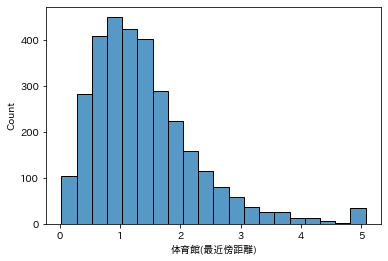

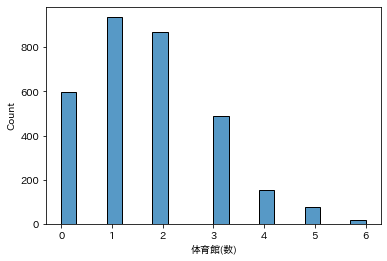

In [132]:
for feature_name in feature_list.keys():
    sns.histplot(df_geo_master[feature_name], bins=20)
    plt.show()

In [133]:
score_list = []
for key, value in feature_list.items():
    df_geo_master[f'{key}レベル'] = rank_score(df_geo_master[key] * value['sort'])
    score_list.append(df_geo_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score)

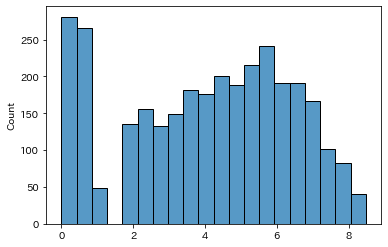

In [134]:
sns.histplot(_tmp_score, bins=20)
plt.show()

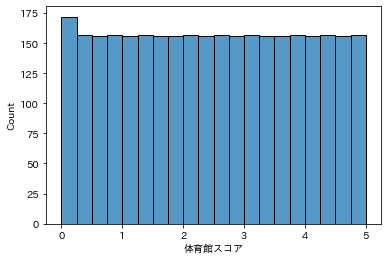

In [135]:
sns.histplot(df_geo_master[score_name], bins=20)
plt.show()

In [136]:
df_geo_master[score_name].describe()

count    3145.000000
mean        2.487614
std         1.451218
min         0.000000
25%         1.231421
50%         2.487614
75%         3.743807
max         5.000000
Name: 体育館スコア, dtype: float64

### プールスコア

In [137]:
score_name = 'プールスコア'
feature_list = {
    'プール(最近傍距離)':       {'sort': -1, 'weight': 1}, 
    'プール(数)':               {'sort': 1, 'weight': 0.7},
}
all_feature_list += list(feature_list.keys())
all_score_list.append(score_name)

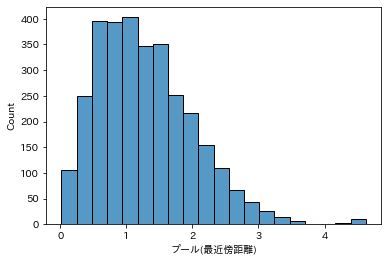

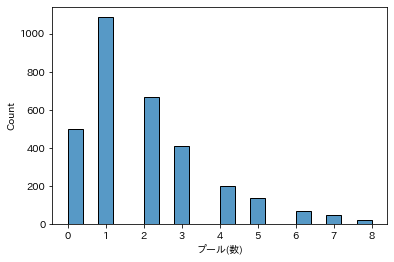

In [138]:
for feature_name in feature_list.keys():
    sns.histplot(df_geo_master[feature_name], bins=20)
    plt.show()

In [139]:
score_list = []
for key, value in feature_list.items():
    df_geo_master[f'{key}レベル'] = rank_score(df_geo_master[key] * value['sort'])
    score_list.append(df_geo_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score)

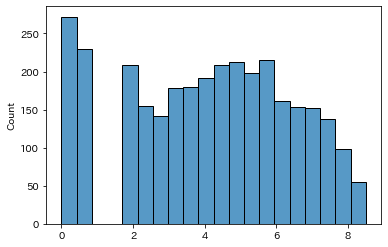

In [140]:
sns.histplot(_tmp_score, bins=20)
plt.show()

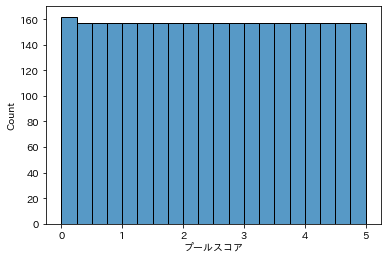

In [141]:
sns.histplot(df_geo_master[score_name], bins=20)
plt.show()

In [142]:
df_geo_master[score_name].describe()

count    3145.000000
mean        2.496018
std         1.446364
min         0.000000
25%         1.244027
50%         2.496018
75%         3.748009
max         5.000000
Name: プールスコア, dtype: float64

### フィットネス

In [143]:
score_name = 'フィットネススコア'
feature_list = {
    'フィットネス(数)':               {'sort': 1, 'weight': 1},
    'テニス教室(数)':               {'sort': 1, 'weight': 0.5},
    'ゴルフ練習場(数)':             {'sort': 1, 'weight': 0.5},
}
all_feature_list += list(feature_list.keys())
all_score_list.append(score_name)

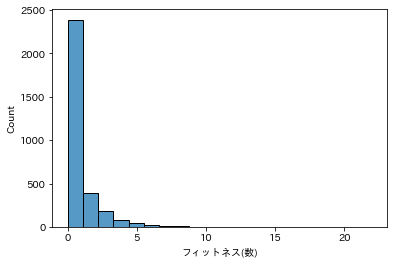

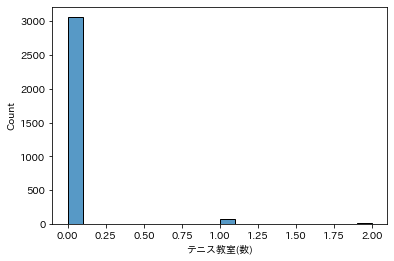

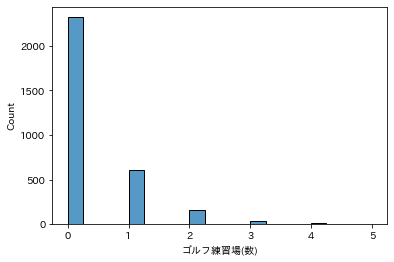

In [144]:
for feature_name in feature_list.keys():
    sns.histplot(df_geo_master[feature_name], bins=20)
    plt.show()

In [145]:
score_list = []
for key, value in feature_list.items():
    df_geo_master[f'{key}レベル'] = rank_score(df_geo_master[key] * value['sort'])
    score_list.append(df_geo_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score)

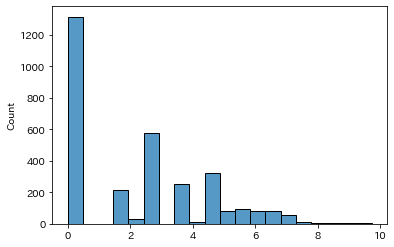

In [146]:
sns.histplot(_tmp_score, bins=20)
plt.show()

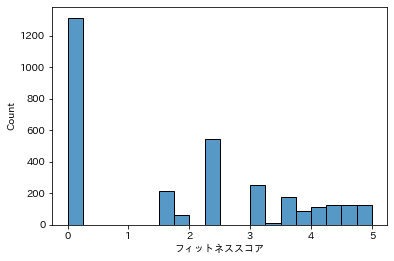

In [147]:
sns.histplot(df_geo_master[score_name], bins=20)
plt.show()

In [148]:
df_geo_master[score_name].describe()

count    3145.000000
mean        1.840201
std         1.751382
min         0.000000
25%         0.000000
50%         1.830151
75%         3.226131
max         5.000000
Name: フィットネススコア, dtype: float64

### 保存

In [149]:
all_feature_list

['運動場他(最近傍距離)',
 '運動場他(数)',
 '体育館(最近傍距離)',
 '体育館(数)',
 'プール(最近傍距離)',
 'プール(数)',
 'フィットネス(数)',
 'テニス教室(数)',
 'ゴルフ練習場(数)']

In [150]:
all_score_list

['運動場スコア', '体育館スコア', 'プールスコア', 'フィットネススコア']

In [151]:
for col in [col for col in all_feature_list if '距離' in col]:
    df_geo_master[col] = df_geo_master[col].round(3)

for col in all_score_list:
    df_geo_master[col] = df_geo_master[col].round(2)

In [152]:
df_geo_master[
    ['town_id'] + all_feature_list + all_score_list
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False, encoding='utf-8_sig')

## 区ごとのスコア確認

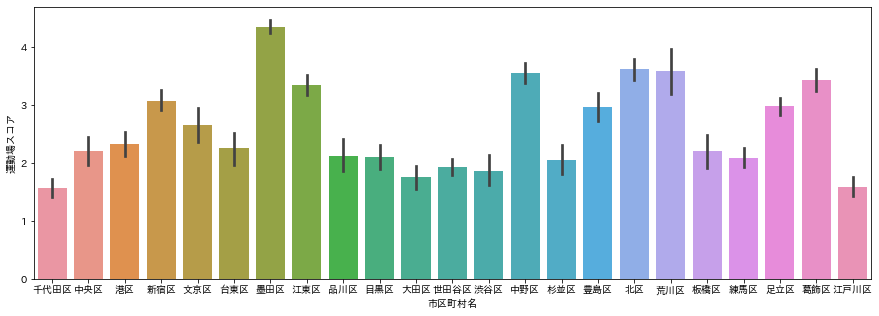

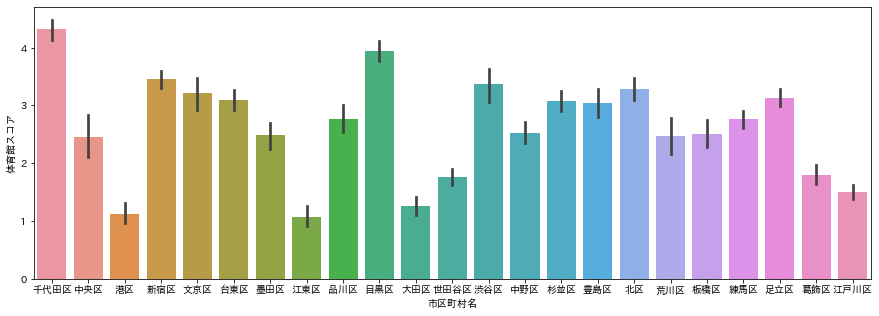

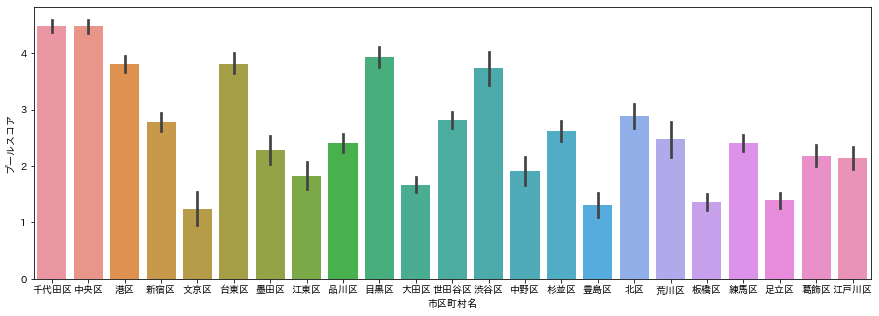

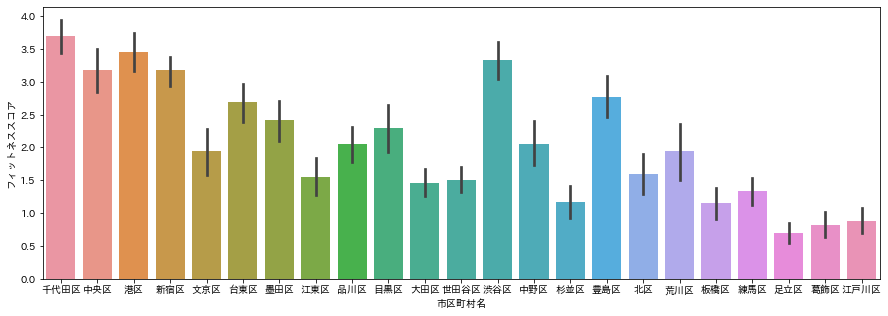

In [153]:
for _score in all_score_list:
    plt.figure(figsize=(15, 5))
    sns.barplot(x='市区町村名', y=_score, data=df_geo_master)
    plt.show()

In [154]:
def get_score_top(df_data, target, ):
    df_level = df_data.copy()
    score_name = f'{target}スコア'
    feature_cols = [col for col in all_feature_list if col.startswith(target)]
    df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
    df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
        ['市区町村名', '町名', '町丁目'] + feature_cols + [score_name]
    ].reset_index(drop=True)
    return df_level

In [155]:
df_level = get_score_top(df_geo_master, '運動場')
print(df_level.shape)
df_level.head(10)

(900, 6)


,市区町村名,町名,町丁目,運動場他(最近傍距離),運動場他(数),運動場スコア
0,墨田区,東墨田,東墨田１丁目,0.062,16,5.00
1,墨田区,堤通,堤通２丁目,0.108,22,5.00
2,荒川区,東尾久,東尾久７丁目,0.090,11,4.99
3,足立区,千住桜木,千住桜木２丁目,0.052,12,4.99
4,葛飾区,小菅,小菅１丁目,0.100,18,4.99
5,葛飾区,四つ木,四つ木３丁目,0.151,22,4.99
6,葛飾区,東四つ木,東四つ木３丁目,0.196,19,4.98
7,台東区,日本堤,日本堤２丁目,0.017,9,4.98
8,葛飾区,東立石,東立石３丁目,0.191,17,4.98
9,墨田区,向島,向島５丁目,0.082,9,4.98


In [156]:
df_level.tail(10)

,市区町村名,町名,町丁目,運動場他(最近傍距離),運動場他(数),運動場スコア
890,江戸川区,東松本,東松本１丁目,2.311,0,0.13
891,練馬区,西大泉町,西大泉町,2.344,0,0.12
892,江戸川区,松本,松本２丁目,2.383,0,0.11
893,千代田区,有楽町,有楽町１丁目,2.387,0,0.10
894,江東区,若洲,若洲１丁目,2.462,0,0.07
895,杉並区,松庵,松庵３丁目,2.495,0,0.07
896,板橋区,東新町,東新町１丁目,2.521,0,0.06
897,千代田区,皇居外苑,皇居外苑,2.523,0,0.06
898,大田区,羽田沖水面,羽田沖水面,4.040,0,0.00
899,大田区,ふるさとの浜辺公園,ふるさとの浜辺公園,4.040,0,0.00


In [157]:
df_level = get_score_top(df_geo_master, '体育館')
print(df_level.shape)
df_level.head(10)

(892, 6)


,市区町村名,町名,町丁目,体育館(最近傍距離),体育館(数),体育館スコア
0,千代田区,神田鍛冶町,神田鍛冶町３丁目,0.223,6,5.00
1,千代田区,鍛冶町,鍛冶町２丁目,0.099,6,5.00
2,千代田区,神田神保町,神田神保町３丁目,0.130,5,5.00
3,文京区,湯島,湯島２丁目,0.124,5,5.00
4,千代田区,神田北乗物町,神田北乗物町,0.208,5,4.99
5,千代田区,神田富山町,神田富山町,0.258,6,4.99
6,千代田区,九段南,九段南１丁目,0.134,5,4.99
7,豊島区,雑司が谷,雑司が谷２丁目,0.226,5,4.98
8,千代田区,神田美倉町,神田美倉町,0.252,5,4.98
9,千代田区,神田西福田町,神田西福田町,0.227,5,4.98


In [158]:
df_level.tail(10)

,市区町村名,町名,町丁目,体育館(最近傍距離),体育館(数),体育館スコア
882,大田区,鵜の木,鵜の木３丁目,3.733,0,0.09
883,大田区,南久が原,南久が原１丁目,3.792,0,0.08
884,世田谷区,喜多見,喜多見６丁目,3.831,0,0.08
885,中央区,豊海町,豊海町,3.990,0,0.07
886,江東区,潮見,潮見１丁目,4.105,0,0.06
887,世田谷区,宇奈根,宇奈根３丁目,4.538,0,0.04
888,江東区,東雲,東雲１丁目,4.542,0,0.03
889,品川区,東八潮,東八潮,5.076,0,0.00
890,大田区,羽田沖水面,羽田沖水面,5.076,0,0.00
891,大田区,ふるさとの浜辺公園,ふるさとの浜辺公園,5.076,0,0.00


In [159]:
df_level = get_score_top(df_geo_master, 'プール')
print(df_level.shape)
df_level.head(10)

(903, 6)


,市区町村名,町名,町丁目,プール(最近傍距離),プール(数),プールスコア
0,千代田区,神田佐久間町,神田佐久間町３丁目,0.167,8,5.00
1,中央区,日本橋浜町,日本橋浜町２丁目,0.087,7,5.00
2,千代田区,神田和泉町,神田和泉町,0.040,8,5.00
3,中央区,日本橋人形町,日本橋人形町１丁目,0.086,8,5.00
4,台東区,台東,台東１丁目,0.234,8,4.99
5,中央区,日本橋小網町,日本橋小網町,0.208,8,4.99
6,中央区,入船,入船１丁目,0.133,7,4.99
7,千代田区,神田佐久間河岸,神田佐久間河岸,0.257,8,4.98
8,千代田区,内神田,内神田２丁目,0.168,6,4.98
9,千代田区,神田多町,神田多町２丁目,0.180,6,4.98


In [160]:
df_level.tail(10)

,市区町村名,町名,町丁目,プール(最近傍距離),プール(数),プールスコア
893,豊島区,千川,千川１丁目,2.782,0,0.15
894,板橋区,大谷口,大谷口２丁目,2.893,0,0.12
895,足立区,皿沼,皿沼３丁目,2.916,0,0.11
896,足立区,西新井本町,西新井本町４丁目,2.958,0,0.11
897,板橋区,大谷口上町,大谷口上町,2.958,0,0.10
898,足立区,谷在家,谷在家１丁目,3.007,0,0.09
899,江戸川区,堀江町,堀江町,3.043,0,0.08
900,江東区,夢の島,夢の島３丁目,3.181,0,0.05
901,大田区,ふるさとの浜辺公園,ふるさとの浜辺公園,4.623,0,0.00
902,大田区,羽田沖水面,羽田沖水面,4.623,0,0.00
